In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dependencies

In [ ]:
import os
import cv2
import numpy as npSCORE = TF×log(10000/DF+1)
import pandas as pd
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import torch
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as album
from pathlib import Path
import torch.nn.functional as F
import torch.optim as optim

# Checking the data given

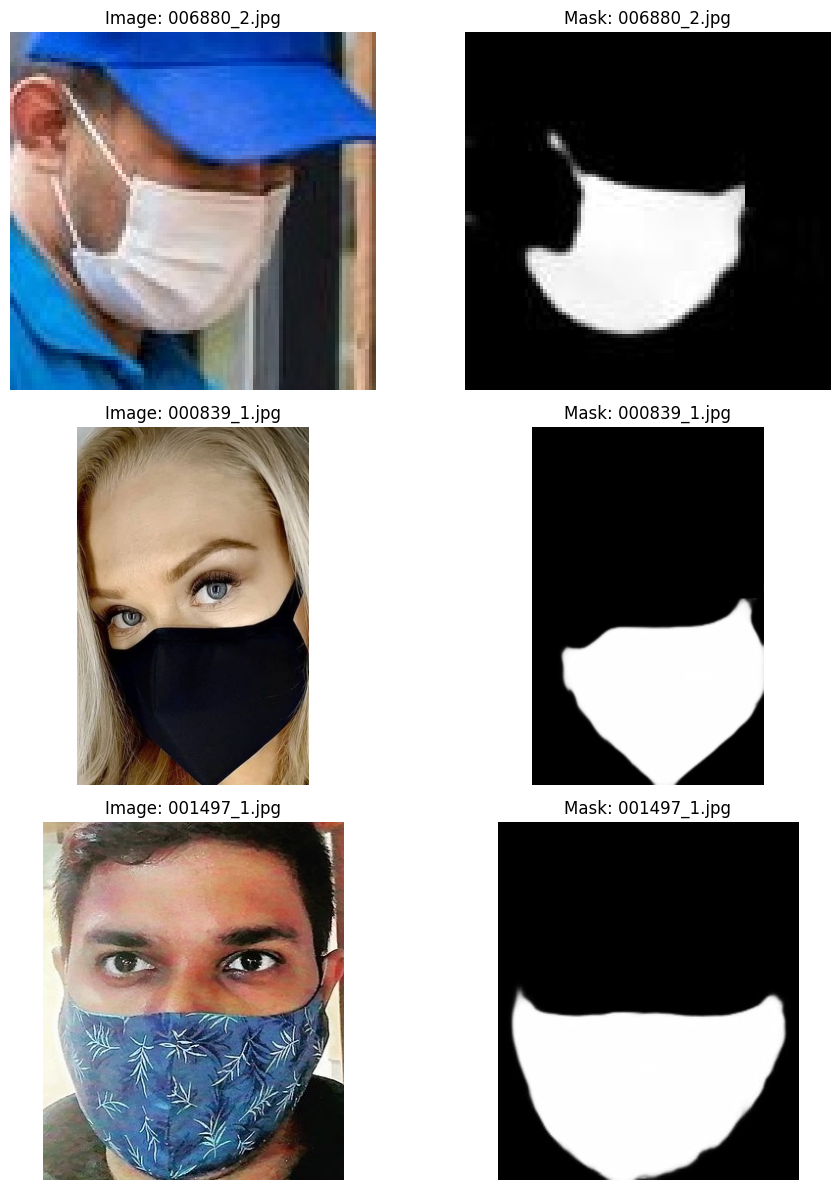

In [34]:

# Function to get sorted filenames while filtering specific unwanted files
def get_filenames(directory, extension=".jpg", exclude_file="000601_1.jpg"):
    """Returns sorted filenames with the given extension from a directory, excluding specific files."""
    return sorted(
        [file for file in os.listdir(directory) if file.endswith(extension) and file != exclude_file]
    )

# Load image and mask filenames
image_dir = Path("/kaggle/input/msfd-miniproj/MSFD/1/face_crop")
mask_dir = Path("/kaggle/input/msfd-miniproj/MSFD/1/face_crop_segmentation")

image_filenames = get_filenames(image_dir)
mask_filenames = get_filenames(mask_dir)

# Function to visualize images alongside their corresponding masks
def visualize_samples(image_dir, mask_dir, image_filenames, mask_filenames, num_samples=5):
    """Displays a selection of images with their corresponding segmentation masks."""
    
    num_samples = min(num_samples, len(image_filenames))
    sample_indices = random.sample(range(len(image_filenames)), num_samples)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))

    for i, idx in enumerate(sample_indices):
        img_path = image_dir / image_filenames[idx]
        mask_path = mask_dir / mask_filenames[idx]

        # Load the image and mask
        image = cv2.imread(str(img_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Handle loading errors
        if image is None or mask is None:
            print(f"Skipping: Unable to load {img_path} or {mask_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'Image: {image_filenames[idx]}')
        axes[i, 0].axis('off')

        # Display mask
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f'Mask: {mask_filenames[idx]}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization with 3 random samples
visualize_samples(image_dir, mask_dir, image_filenames, mask_filenames, num_samples=3)


# Creating the Dataset Class

In [ ]:
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (3, 256, 256)  # channel-first



class MaskedFaceDataset(Dataset):
    def __init__(self, actual_img_dir, mask_img_dir, image_names, mask_names, input_size, augmented):
        self.actual_img_dir = actual_img_dir
        self.mask_img_dir = mask_img_dir
        self.image_names = image_names
        self.mask_names = mask_names
        self.input_size = input_size
        self.augmented = augmented

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.actual_img_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_img_dir, self.mask_names[idx])

        # Load and resize image and mask
        img = Image.open(img_path).convert('RGB').resize(self.input_size)
        mask = Image.open(mask_path).convert('L').resize(self.input_size)

        # Convert to NumPy arrays
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
        mask_array = np.array(mask, dtype=bool).astype(np.float32)  # Convert to binary mask

        # Convert HWC to CHW format
        img_array = np.transpose(img_array, (2, 0, 1))  # (C, H, W)
        mask_array = np.expand_dims(mask_array, axis=0)  # (1, H, W)

        images = [img_array]
        masks = [mask_array]

        # Apply augmentation if enabled
        if self.augmented:
            img_hflip = np.flip(img_array, axis=2).copy()  # Horizontal flip
            mask_hflip = np.flip(mask_array, axis=2).copy()
            images.append(img_hflip)
            masks.append(mask_hflip)

            img_vflip = np.flip(img_array, axis=1).copy()  # Vertical flip
            mask_vflip = np.flip(mask_array, axis=1).copy()
            images.append(img_vflip)
            masks.append(mask_vflip)

        return torch.tensor(images[0], dtype=torch.float32), torch.tensor(masks[0], dtype=torch.float32)

# Split dataset into train, validation, and test
all_indices = np.arange(len(image_filenames))
train_val_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=47)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=47)

# Creating train, valid, test dataset

In [36]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

def subset_dataset(actual_img_dir, mask_img_dir, image_filenames, mask_filenames, indices, input_size, augment):
    subset_images = [image_filenames[i] for i in indices]
    subset_masks = [mask_filenames[i] for i in indices]
    return MaskedFaceDataset(actual_img_dir, mask_img_dir, subset_images, subset_masks, input_size, augment)

# Create subsets from the original dataset
train_dataset = subset_dataset(
    actual_img_dir="/kaggle/input/msfd-miniproj/MSFD/1/face_crop",
    mask_img_dir="/kaggle/input/msfd-miniproj/MSFD/1/face_crop_segmentation",
    image_filenames=image_filenames,
    mask_filenames=mask_filenames,
    indices=train_idx,
    input_size=INPUT_SIZE,
    augment=True  # Apply augmentation only for training
)

val_dataset = subset_dataset(
    actual_img_dir="/kaggle/input/msfd-miniproj/MSFD/1/face_crop",
    mask_img_dir="/kaggle/input/msfd-miniproj/MSFD/1/face_crop_segmentation",
    image_filenames=image_filenames,
    mask_filenames=mask_filenames,
    indices=val_idx,
    input_size=INPUT_SIZE,
    augment=False  # No augmentation for validation
)

test_dataset = subset_dataset(
    actual_img_dir="/kaggle/input/msfd-miniproj/MSFD/1/face_crop",
    mask_img_dir="/kaggle/input/msfd-miniproj/MSFD/1/face_crop_segmentation",
    image_filenames=image_filenames,
    mask_filenames=mask_filenames,
    indices=test_idx,
    input_size=INPUT_SIZE,
    augment=False  # No augmentation for test set
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 6004
Validation dataset size: 1501
Test dataset size: 1877


# U-Net Model structure

In [ ]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_layer):
        super(UNet, self).__init__()

        # Encoder Blocks
        self.enc1 = self._conv_block(input_channels, 16, dropout=0.1)
        self.enc2 = self._conv_block(16, 32, dropout=0.1)
        self.enc3 = self._conv_block(32, 64, dropout=0.2)
        self.enc4 = self._conv_block(64, 128, dropout=0.2)

        # Bottom (Bottleneck)
        self.bottleneck = self._conv_block(128, 256, dropout=0.3)

        # Decoder Blocks
        self.up6 = self._up_conv(256, 128)
        self.dec6 = self._conv_block(256, 128, dropout=0.2)

        self.up7 = self._up_conv(128, 64)
        self.dec7 = self._conv_block(128, 64, dropout=0.2)

        self.up8 = self._up_conv(64, 32)
        self.dec8 = self._conv_block(64, 32, dropout=0.1)

        self.up9 = self._up_conv(32, 16)
        self.dec9 = self._conv_block(32, 16, dropout=0.1)

        # Output Layer
        self.out_conv = nn.Conv2d(16, output_layer, kernel_size=1)

    def _conv_block(self, in_channels, out_channels, dropout=0.0):
        """Creates a convolutional block with BatchNorm, ReLU, and optional Dropout."""
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        return nn.Sequential(*layers)

    def _up_conv(self, in_channels, out_channels):
        """Creates an upsampling block using transposed convolution."""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder Path
        enc1 = self.enc1(x)
        pool1 = F.max_pool2d(enc1, kernel_size=2, stride=2)

        enc2 = self.enc2(pool1)
        pool2 = F.max_pool2d(enc2, kernel_size=2, stride=2)

        enc3 = self.enc3(pool2)
        pool3 = F.max_pool2d(enc3, kernel_size=2, stride=2)

        enc4 = self.enc4(pool3)
        pool4 = F.max_pool2d(enc4, kernel_size=2, stride=2)

        # Bottleneck
        bottleneck = self.bottleneck(pool4)

        # Decoder Path
        up6 = self.up6(bottleneck)
        merge6 = torch.cat([enc4, up6], dim=1)
        dec6 = self.dec6(merge6)

        up7 = self.up7(dec6)
        merge7 = torch.cat([enc3, up7], dim=1)
        dec7 = self.dec7(merge7)

        up8 = self.up8(dec7)
        merge8 = torch.cat([enc2, up8], dim=1)
        dec8 = self.dec8(merge8)

        up9 = self.up9(dec8)
        merge9 = torch.cat([enc1, up9], dim=1)
        dec9 = self.dec9(merge9)

        # Output Layer
        output = torch.sigmoid(self.out_conv(dec9))
        return output


# Instantiate model
INPUT_SHAPE = (3, 256, 256)  # Example input shape
model = UNet(input_channels=INPUT_SHAPE[0], output_layer=1)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Learning Rate Scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)


# Training the model

In [38]:
import torch
import torch.nn as nn
import os
from tqdm import tqdm
import segmentation_models_pytorch as smp

# IoU Metric Function (Using smp)
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

def calculate_iou(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = (outputs > 0.5).float()  # Convert predictions to binary
    labels = labels.float()
    return iou_metric(outputs.cpu(), labels.cpu()).item()


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = y_true.float()  # Convert y_true to float32
    y_pred = y_pred.float()
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = nn.BCELoss()(y_pred, y_true)
    return bce + dice_loss(y_true, y_pred)

train_logs_list = []
valid_logs_list = []

# Training Configuration
epochs = 50
best_val_loss = float("inf")
save_path = "models/save_best.pth"
os.makedirs("models", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = DiceTverskyLoss()  # Use new loss function
print(f"Using device: {device}")

for epoch in range(epochs):
    model.train()
    train_dice, train_iou = 0.0, 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [TRAIN]", bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} ETA: {remaining}")

    for imgs, masks in train_loader_tqdm:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = torch.sigmoid(outputs)

        loss = criterion(masks, outputs)
        loss.backward()
        optimizer.step()

        train_dice += dice_coefficient(masks, outputs).item() * imgs.size(0)
        train_iou += calculate_iou(outputs, masks) * imgs.size(0)

        train_loader_tqdm.set_postfix(dice=train_dice / len(train_loader.dataset), iou=train_iou / len(train_loader.dataset))

    train_dice /= len(train_loader.dataset)
    train_iou /= len(train_loader.dataset)

    # Validation Phase
    model.eval()
    val_dice, val_iou,val_loss = 0.0, 0.0, 0.0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [VAL]", bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} ETA: {remaining}")

    with torch.no_grad():
        for imgs, masks in val_loader_tqdm:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            outputs = torch.sigmoid(outputs)
            loss = bce_dice_loss(masks, outputs).to(device)

            val_loss += loss.item() * imgs.size(0)

            val_dice += dice_coefficient(masks, outputs).item() * imgs.size(0)
            val_iou += calculate_iou(outputs, masks) * imgs.size(0)
            loss = bce_dice_loss(masks, outputs).to(device)
            val_loss += loss.item() * imgs.size(0)
            
            val_loader_tqdm.set_postfix(dice=val_dice / len(val_loader.dataset), iou=val_iou / len(val_loader.dataset))
    val_loss /= len(val_loader.dataset)
    val_dice /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs} - Train Dice: {train_dice:.4f} - Train IoU: {train_iou:.4f} - Val Dice: {val_dice:.4f} - Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved best model.")

    lr_scheduler.step(val_loss)
    train_logs_list.append({'epoch': epoch + 1, 'train_iou': train_iou, 'train_dice': train_dice})
    valid_logs_list.append({'epoch': epoch + 1, 'val_iou': val_iou, 'val_dice': val_dice})
    
    


Using device: cuda


Epoch 1/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 1/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 1/50 - Train Dice: 0.5440 - Train IoU: 0.3817 - Val Dice: 0.5530 - Val IoU: 0.3847
Saved best model.


Epoch 2/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 2/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 2/50 - Train Dice: 0.5578 - Train IoU: 0.3817 - Val Dice: 0.5594 - Val IoU: 0.3847
Saved best model.


Epoch 3/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 3/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 3/50 - Train Dice: 0.5599 - Train IoU: 0.3817 - Val Dice: 0.5603 - Val IoU: 0.3847
Saved best model.


Epoch 4/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 4/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 4/50 - Train Dice: 0.5611 - Train IoU: 0.3817 - Val Dice: 0.5621 - Val IoU: 0.3847
Saved best model.


Epoch 5/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 5/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 5/50 - Train Dice: 0.5619 - Train IoU: 0.3817 - Val Dice: 0.5596 - Val IoU: 0.3847


Epoch 6/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 6/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 6/50 - Train Dice: 0.5623 - Train IoU: 0.3827 - Val Dice: 0.5607 - Val IoU: 0.3848


Epoch 7/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 7/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 7/50 - Train Dice: 0.5625 - Train IoU: 0.3966 - Val Dice: 0.5629 - Val IoU: 0.3877
Saved best model.


Epoch 8/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 8/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 8/50 - Train Dice: 0.5627 - Train IoU: 0.4529 - Val Dice: 0.5628 - Val IoU: 0.4092


Epoch 9/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 9/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 9/50 - Train Dice: 0.5631 - Train IoU: 0.5395 - Val Dice: 0.5650 - Val IoU: 0.5558
Saved best model.


Epoch 10/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 10/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 10/50 - Train Dice: 0.5634 - Train IoU: 0.6294 - Val Dice: 0.5645 - Val IoU: 0.6705


Epoch 11/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 11/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 11/50 - Train Dice: 0.5634 - Train IoU: 0.6942 - Val Dice: 0.5641 - Val IoU: 0.7537


Epoch 12/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 12/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 12/50 - Train Dice: 0.5637 - Train IoU: 0.7391 - Val Dice: 0.5656 - Val IoU: 0.7898
Saved best model.


Epoch 13/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 13/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 13/50 - Train Dice: 0.5638 - Train IoU: 0.7611 - Val Dice: 0.5649 - Val IoU: 0.7929


Epoch 14/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 14/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 14/50 - Train Dice: 0.5640 - Train IoU: 0.7770 - Val Dice: 0.5644 - Val IoU: 0.7709


Epoch 15/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 15/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 15/50 - Train Dice: 0.5642 - Train IoU: 0.7963 - Val Dice: 0.5650 - Val IoU: 0.8042


Epoch 16/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 16/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 16/50 - Train Dice: 0.5642 - Train IoU: 0.8079 - Val Dice: 0.5656 - Val IoU: 0.8216


Epoch 17/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 17/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 17/50 - Train Dice: 0.5651 - Train IoU: 0.8232 - Val Dice: 0.5660 - Val IoU: 0.8202


Epoch 18/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 18/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 18/50 - Train Dice: 0.5654 - Train IoU: 0.8231 - Val Dice: 0.5663 - Val IoU: 0.8167
Saved best model.


Epoch 19/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 19/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 19/50 - Train Dice: 0.5653 - Train IoU: 0.8219 - Val Dice: 0.5665 - Val IoU: 0.8216
Saved best model.


Epoch 20/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 20/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 20/50 - Train Dice: 0.5656 - Train IoU: 0.8247 - Val Dice: 0.5662 - Val IoU: 0.8208


Epoch 21/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 21/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 21/50 - Train Dice: 0.5657 - Train IoU: 0.8281 - Val Dice: 0.5661 - Val IoU: 0.8173


Epoch 22/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 22/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 22/50 - Train Dice: 0.5658 - Train IoU: 0.8334 - Val Dice: 0.5665 - Val IoU: 0.8334


Epoch 23/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 23/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 23/50 - Train Dice: 0.5658 - Train IoU: 0.8359 - Val Dice: 0.5664 - Val IoU: 0.8306


Epoch 24/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 24/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 24/50 - Train Dice: 0.5660 - Train IoU: 0.8375 - Val Dice: 0.5666 - Val IoU: 0.8338
Saved best model.


Epoch 25/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 25/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 25/50 - Train Dice: 0.5660 - Train IoU: 0.8375 - Val Dice: 0.5666 - Val IoU: 0.8321


Epoch 26/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 26/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 26/50 - Train Dice: 0.5660 - Train IoU: 0.8377 - Val Dice: 0.5668 - Val IoU: 0.8374
Saved best model.


Epoch 27/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 27/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 27/50 - Train Dice: 0.5661 - Train IoU: 0.8368 - Val Dice: 0.5667 - Val IoU: 0.8323


Epoch 28/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 28/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 28/50 - Train Dice: 0.5661 - Train IoU: 0.8365 - Val Dice: 0.5665 - Val IoU: 0.8254


Epoch 29/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 29/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 29/50 - Train Dice: 0.5661 - Train IoU: 0.8375 - Val Dice: 0.5667 - Val IoU: 0.8318


Epoch 30/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 30/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 30/50 - Train Dice: 0.5661 - Train IoU: 0.8376 - Val Dice: 0.5665 - Val IoU: 0.8259


Epoch 31/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 31/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 31/50 - Train Dice: 0.5662 - Train IoU: 0.8373 - Val Dice: 0.5665 - Val IoU: 0.8253


Epoch 32/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 32/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 32/50 - Train Dice: 0.5660 - Train IoU: 0.8368 - Val Dice: 0.5666 - Val IoU: 0.8249


Epoch 33/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 33/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 33/50 - Train Dice: 0.5662 - Train IoU: 0.8371 - Val Dice: 0.5667 - Val IoU: 0.8292


Epoch 34/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 34/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 34/50 - Train Dice: 0.5662 - Train IoU: 0.8376 - Val Dice: 0.5667 - Val IoU: 0.8299


Epoch 35/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 35/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 35/50 - Train Dice: 0.5661 - Train IoU: 0.8378 - Val Dice: 0.5667 - Val IoU: 0.8294


Epoch 36/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 36/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 36/50 - Train Dice: 0.5662 - Train IoU: 0.8383 - Val Dice: 0.5665 - Val IoU: 0.8262


Epoch 37/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 37/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 37/50 - Train Dice: 0.5662 - Train IoU: 0.8379 - Val Dice: 0.5665 - Val IoU: 0.8286


Epoch 38/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 38/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 38/50 - Train Dice: 0.5662 - Train IoU: 0.8376 - Val Dice: 0.5665 - Val IoU: 0.8239


Epoch 39/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 39/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 39/50 - Train Dice: 0.5662 - Train IoU: 0.8380 - Val Dice: 0.5665 - Val IoU: 0.8244


Epoch 40/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 40/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 40/50 - Train Dice: 0.5663 - Train IoU: 0.8383 - Val Dice: 0.5666 - Val IoU: 0.8292


Epoch 41/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 41/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 41/50 - Train Dice: 0.5662 - Train IoU: 0.8379 - Val Dice: 0.5666 - Val IoU: 0.8267


Epoch 42/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 42/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 42/50 - Train Dice: 0.5662 - Train IoU: 0.8380 - Val Dice: 0.5667 - Val IoU: 0.8330


Epoch 43/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 43/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 43/50 - Train Dice: 0.5661 - Train IoU: 0.8376 - Val Dice: 0.5667 - Val IoU: 0.8310


Epoch 44/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 44/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 44/50 - Train Dice: 0.5661 - Train IoU: 0.8376 - Val Dice: 0.5666 - Val IoU: 0.8266


Epoch 45/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 45/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 45/50 - Train Dice: 0.5662 - Train IoU: 0.8378 - Val Dice: 0.5667 - Val IoU: 0.8329


Epoch 46/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 46/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 46/50 - Train Dice: 0.5662 - Train IoU: 0.8380 - Val Dice: 0.5665 - Val IoU: 0.8287


Epoch 47/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 47/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 47/50 - Train Dice: 0.5662 - Train IoU: 0.8379 - Val Dice: 0.5667 - Val IoU: 0.8318


Epoch 48/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 48/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 48/50 - Train Dice: 0.5662 - Train IoU: 0.8381 - Val Dice: 0.5665 - Val IoU: 0.8300


Epoch 49/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 49/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 49/50 - Train Dice: 0.5661 - Train IoU: 0.8376 - Val Dice: 0.5666 - Val IoU: 0.8319


Epoch 50/50 [TRAIN]: 100%|██████████ 1501/1501 ETA: 00:00
Epoch 50/50 [VAL]: 100%|██████████ 376/376 ETA: 00:00


Epoch 50/50 - Train Dice: 0.5662 - Train IoU: 0.8379 - Val Dice: 0.5668 - Val IoU: 0.8360
Saved best model.


# Plotting IOU and DICE plots

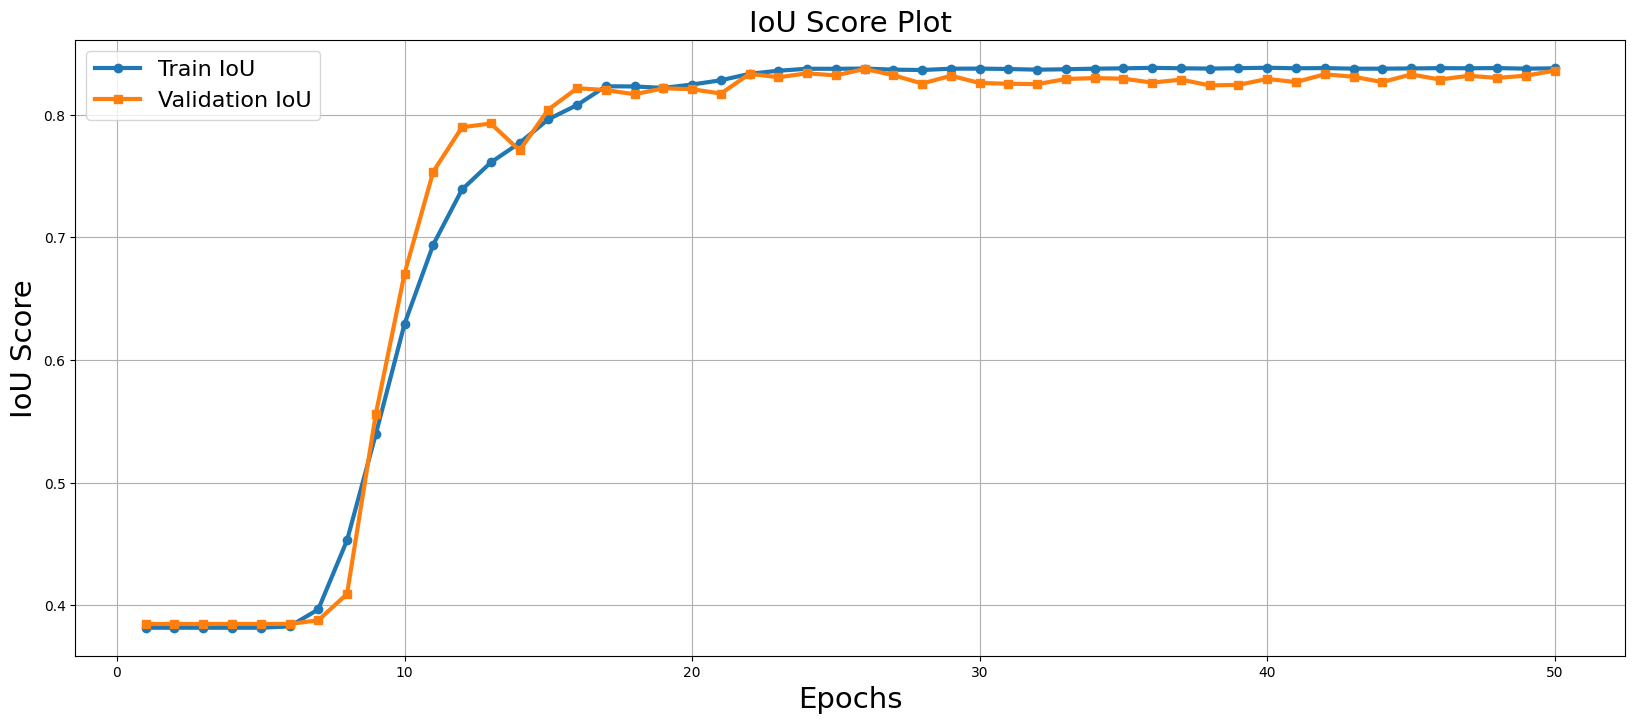

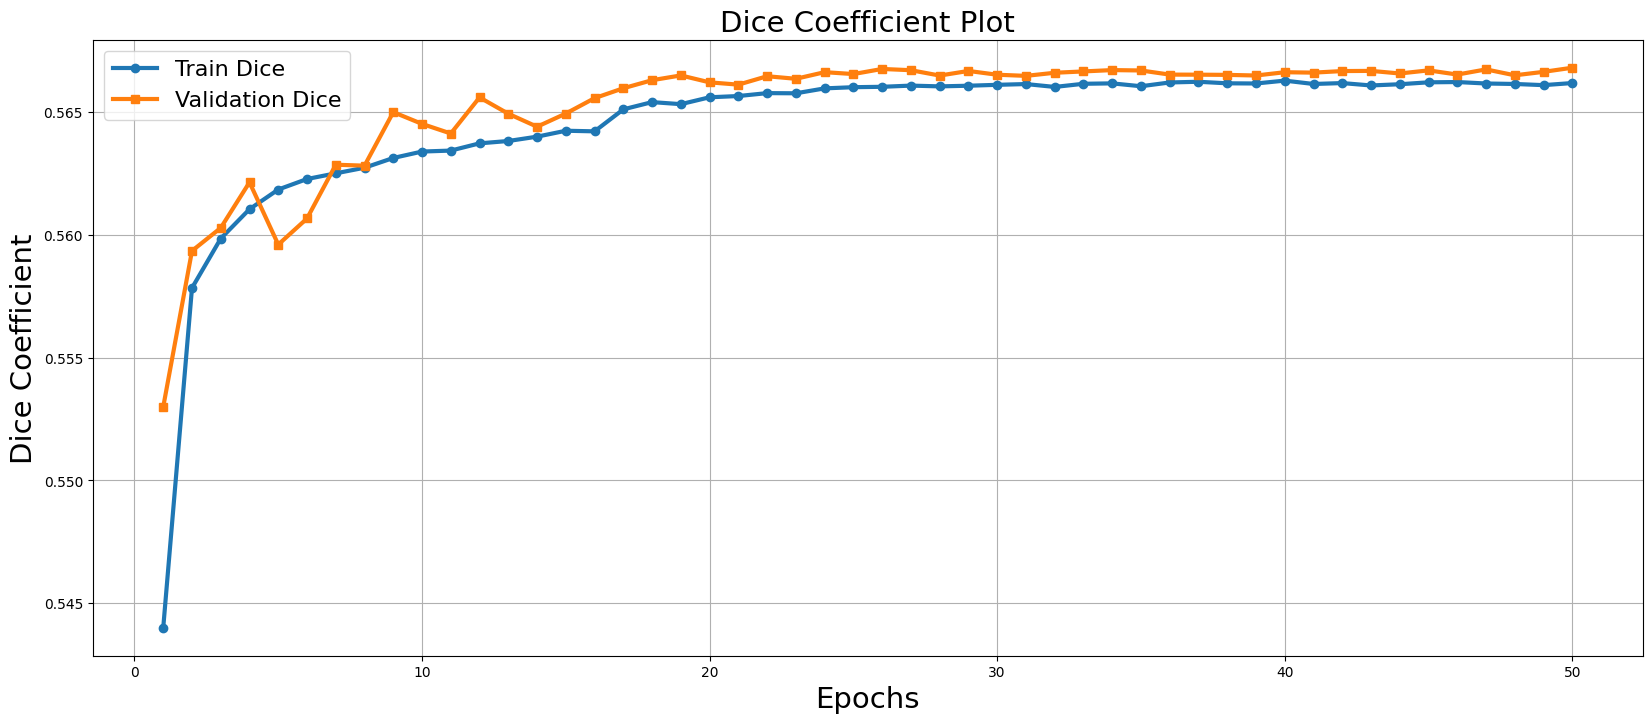

In [39]:

# Convert lists to DataFrame
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

# 📊 Plot IoU Scores
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_iou'], lw=3, label='Train IoU', marker='o')
plt.plot(valid_logs_df['epoch'], valid_logs_df['val_iou'], lw=3, label='Validation IoU', marker='s')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid(True)
plt.savefig('iou_score_plot.png')
plt.show()

# 📊 Plot Dice Coefficients
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_dice'], lw=3, label='Train Dice', marker='o')
plt.plot(valid_logs_df['epoch'], valid_logs_df['val_dice'], lw=3, label='Validation Dice', marker='s')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Coefficient', fontsize=21)
plt.title('Dice Coefficient Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid(True)
plt.savefig('dice_coefficient_plot.png')
plt.show()

# Testing the model

In [40]:
def test_phase():
    best_model = model  # Assign best_model to the trained model
    best_model.eval()   # Set model to evaluation mode


    test_loss, test_dice, test_iou = 0.0, 0.0, 0.0

    test_loader_tqdm = tqdm(test_loader, desc="[TEST]", bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} ETA: {remaining}")

    with torch.no_grad():
        for imgs, masks in test_loader_tqdm:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = best_model(imgs)
            outputs = torch.sigmoid(outputs)

            loss = criterion(masks, outputs)
            test_loss += loss.item() * imgs.size(0)
            test_dice += dice_coefficient(masks, outputs).item() * imgs.size(0)
            test_iou += calculate_iou(outputs, masks) * imgs.size(0)

            test_loader_tqdm.set_postfix(dice=test_dice / len(test_loader.dataset), iou=test_iou / len(test_loader.dataset))

    test_loss /= len(test_loader.dataset)
    test_dice /= len(test_loader.dataset)
    test_iou /= len(test_loader.dataset)

    print(f"Test Results - Loss: {test_loss:.4f}, Dice: {test_dice:.4f}, IoU: {test_iou:.4f}")

# Run the test phase
test_phase()

[TEST]: 100%|██████████ 470/470 ETA: 00:00

Test Results - Loss: 0.4749, Dice: 0.5669, IoU: 0.8331


# Results of Testing

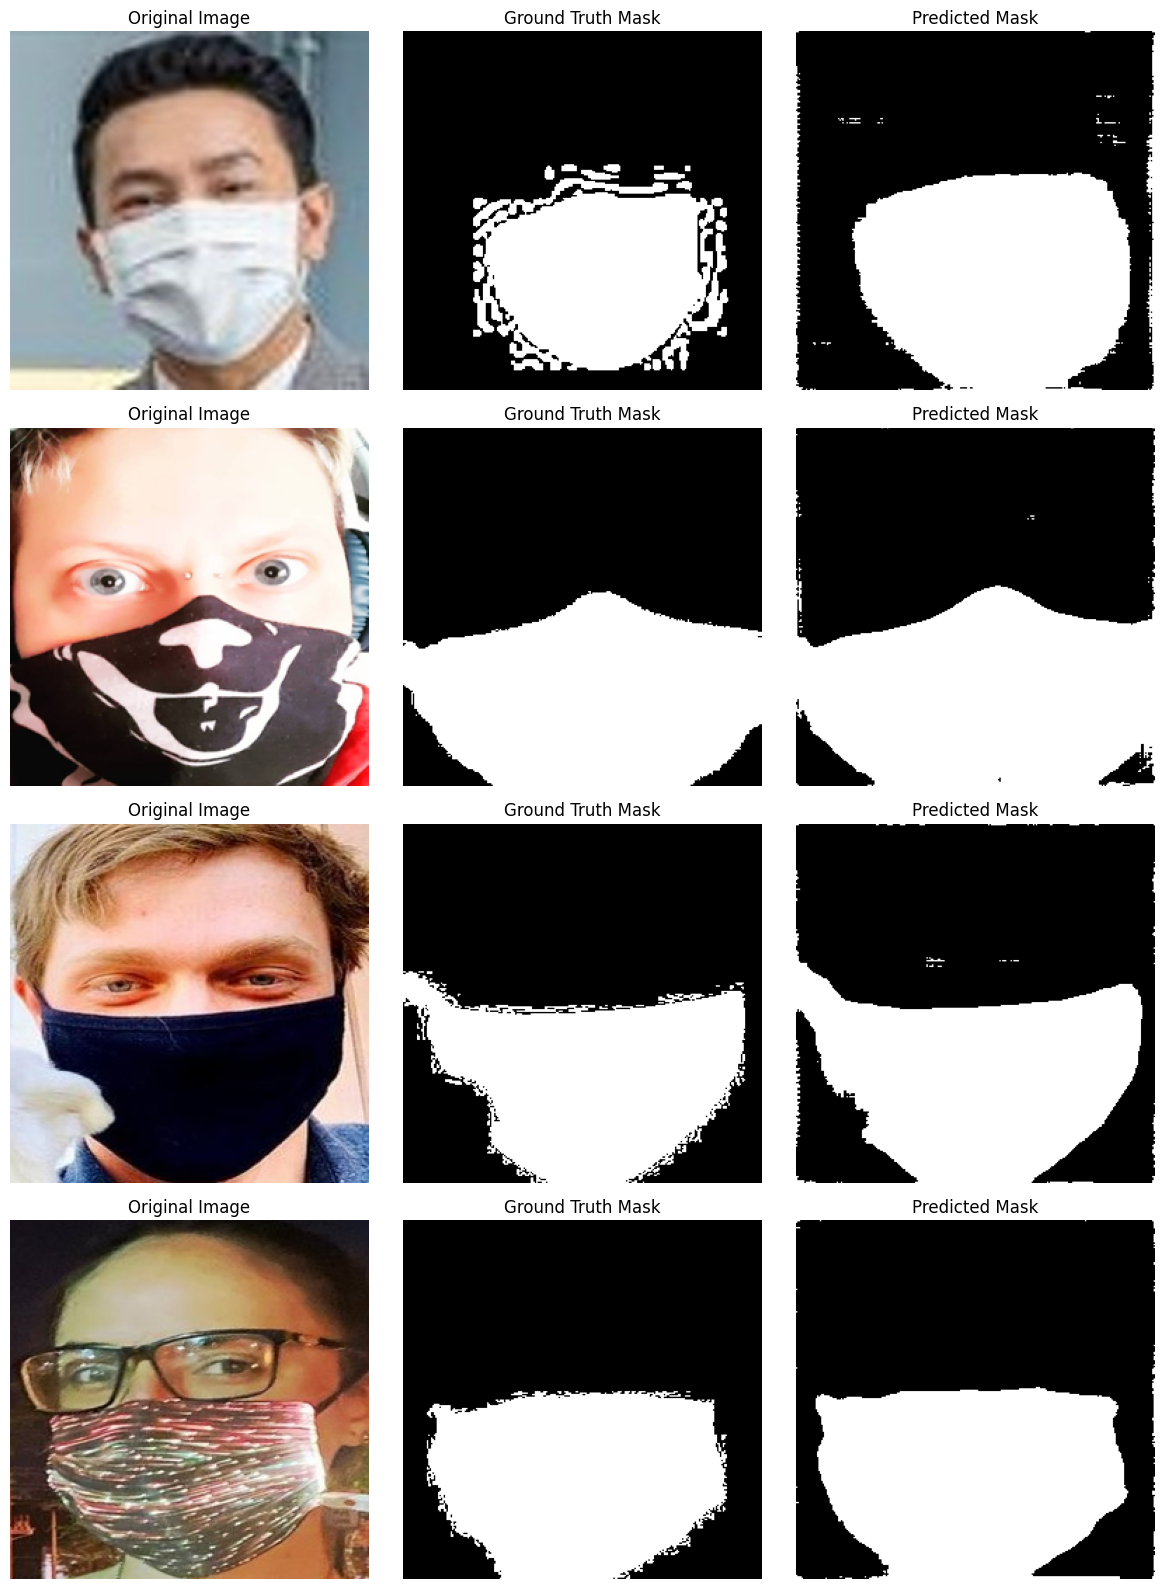

In [41]:
import torchvision.transforms as transforms
# Convert tensor to PIL Image
to_pil = transforms.ToPILImage()

# Function to display results
def visualize_results(images, ground_truths, predictions):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))

    for i in range(num_images):
        # Original Image
        axes[i, 0].imshow(to_pil(images[i].cpu()))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Ground Truth Mask
        axes[i, 1].imshow(ground_truths[i].cpu().squeeze(), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Predicted Mask
        axes[i, 2].imshow(predictions[i].cpu().squeeze(), cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Run inference on test images
with torch.no_grad():
    for images, ground_truths in test_loader:
        images = images.to(device)
        ground_truths = ground_truths.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)  # Convert to probability
        predictions = (predictions > 0.5).float()  # Binarize

        # Display the first 5 images with predictions
        visualize_results(images, ground_truths, predictions)
        break  # Only show one batch